In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import scikit_posthocs as sp
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def plot_variables(df):
    fig, ax = plt.subplots(len(df.columns), len(df.columns))
    for axes in ax:
        for a in axes:
            a.set_xticklabels([])
            a.set_yticklabels([])
    plt.subplots_adjust(wspace=0, hspace=0)
    colors = ['r', 'm', 'k', 'g', 'c', 'b']
    
    for (i, x) in enumerate(df.columns.values):
        for (j, y) in enumerate(df.columns.values):
            if i != j: 
                ax[j][i].scatter(df[x], df[y], s=0.5, color=colors[i], alpha=0.3)
                ax[j][i].margins(0.25, 0.25)
            else:
                ax[j][i].text(0.5, 0.5, x.replace('Temperature', 'Temp'), color=colors[i],
                              horizontalalignment='center',verticalalignment='center', transform=ax[i][j].transAxes)
                
            ax[i][j].tick_params(left=False, right=False , labelleft=False,
                                labelbottom=False, bottom=False)

INITIAL ANALYSES



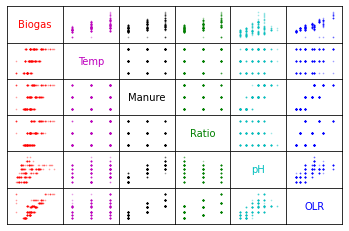

In [3]:
print('INITIAL ANALYSES\n')
df = pd.read_csv('data\\for_model\\biogas.csv')
del df['Essay']
plot_variables(df)

In [4]:
#visualize the results of a post-hoc nemenyi analysis on a cochran's q test using matplotlib in a matrix
def visualize_nemenyi(nemenyi_values, names):
    plt.matshow(nemenyi_values)
    ax = plt.gca()
    ax.xaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_xticklabels(labels=names,rotation=90)
    ax.yaxis.set_major_locator(matplotlib.ticker.FixedLocator(range(len(names))))
    ax.set_yticklabels(labels=names)
    plt.title('Nemenyi post-hoc analysis on model similarity')
    
    #pulled these next two lines from stack overflow, just to display the values
    for (i, j), z in np.ndenumerate(nemenyi_values):
        ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
        
    plt.pause(0.1)

#evaluate a df of model values with column `Actual` being the actual classifications
def evaluate(model_df):
    '''
    Evaluate df of model answers, `Actual` being correct answers.
    Metric: MSE.
    Prints out series with MSE for each algorithm, Friedman Chi Square p-value and statistic,
    and post-hoc Nemenyi test results.
    '''
    actual = model_df['Actual'].to_numpy()
    model_df = model_df.drop('Actual', axis=1)
    models = model_df.to_numpy()
    (statistic, pvalue) = stats.friedmanchisquare(*models)
    print(f'Friedman chi squre test statistic: {statistic:.2f}, p-value: {pvalue:.5f}.\n')
    
    errors = (models.T - actual)**2
    mse = np.sqrt(np.mean(errors, axis=1))
    series = pd.Series(data=mse, index=model_df.columns.values).sort_values()
    series = series.apply(lambda x: f'{x:.0f}')
    print('Root mean squared errors:')
    print(series)
    
    nemenyi_result = sp.posthoc_nemenyi_friedman(models)
    visualize_nemenyi(nemenyi_result, model_df.columns.values)

MODEL EVALUATION

Friedman chi squre test statistic: 1690.27, p-value: 0.00000.

Root mean squared errors:
forest      236
regtree     244
xgboost     245
poly2       258
linear      310
l1          313
l2          316
poly3       321
svm        1372
dtype: object


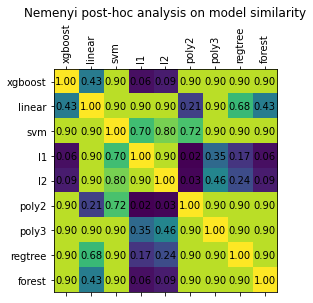

In [5]:
print('MODEL EVALUATION\n')
models_df = pd.read_csv('.\\data\\for_model\\answers.csv')
evaluate(models_df)

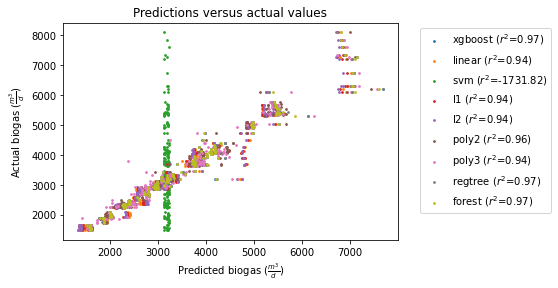

In [6]:
models = [column for column in models_df.columns.values if column != 'Actual']
y = list(models_df['Actual'])
fig, ax = plt.subplots()
for model in models:
    x = list(models_df[model])
    r_squared = metrics.r2_score(x, y)
    ax.scatter(x, y, s=3, label=f'{model} ($r^2$={r_squared:.2f})')
    plt.title(f'Predictions versus actual values')
    ax.set_xlabel(r'Predicted biogas ($\frac{m^3}{d}$)')
    ax.set_ylabel(r'Actual biogas ($\frac{m^3}{d}$)')
    ax.legend(bbox_to_anchor=(1.05, 1))
    plt.plot()